In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle
import numpy as np

import foolbox
import eagerpy as ep

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import cv2

In [2]:
test_path = 'datasets/HAM10000/HAM10000_images_test'
batch_size= 16
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
image_size = 224

print("\nTest Batches: ")
test_batches = datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)


Test Batches: 
Found 828 images belonging to 7 classes.


In [3]:
with open("../Attention-based-Skin-Cancer-Classification/Ham10000 models/Model without Soft Attention/Derm_model.pkl","rb") as file:
    model_without_attention = pickle.load(file)
with open("../Attention-based-Skin-Cancer-Classification/Ham10000 models/Model With Soft Attention/Derm+SA_model.pkl","rb") as file:
    model_with_attention = pickle.load(file)

2022-07-08 14:18:50.790286: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 14:18:50.816879: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 14:18:50.817020: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 14:18:50.817505: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
model_name = "with_attention"
models = {"with_attention":model_with_attention, "without_attention":model_without_attention}
model = models[model_name]
preprocessing = dict()
bounds = (-123.69, 151.062)
fmodel = foolbox.TensorFlowModel(model, bounds=bounds, preprocessing=preprocessing)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-07-08 14:19:02.520557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 14:19:02.520737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 14:19:02.520839: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 14:19:02.520979: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 14:19:02.521084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [13]:
batch_accs = []
batch_weights = []
for i,(x,y) in zip(range(len(test_batches)),test_batches):
    # if i == 0:
    #     print(type(x),y)
    acc = fb.utils.accuracy(fmodel, x, tf.argmax(y, axis=1))
    batch_accs.append(acc)
    batch_weights.append(y.shape[0])
s1 = 0
s2 = sum(batch_weights)
for i in range(len(batch_accs)):
    s1 += batch_accs[i] * batch_weights[i]
print("unperturbed acc:",s1/s2)


2022-07-08 13:07:58.593057: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400


unperturbed acc: 0.886473430239636


In [45]:
attack = fb.attacks.LinfPGD()
adv_batches = []
labels = []
for i,(x,y) in zip(range(len(test_batches)),test_batches):
    raw, clipped, is_adv = attack(fmodel, tf.constant(x), tf.argmax(y, axis=1), epsilons=[0.00125])
    adv_batches.append(clipped[0])
    labels.append(tf.argmax(y, axis=1))

batch_accs = []
batch_weights = []
for (batch,label) in zip(adv_batches, labels):
    x = np.array(batch)
    y = np.array(label)
    acc = fb.utils.accuracy(fmodel, x, y)
    batch_accs.append(acc)
    batch_weights.append(y.shape[0])
s1 = 0
s2 = sum(batch_weights)
for i in range(len(batch_accs)):
    s1 += batch_accs[i] * batch_weights[i]
print("perturbed acc:",s1/s2)


KeyboardInterrupt: 

Using `LinfPGD()`

| Model/Epsilon     | 0                   | 0.00125             | 0.0025              | 0.005               | 0.01                |
| ----------------- | ------------------- | ------------------- | ------------------- | ------------------- | ------------------- |
| Without Attention | 0.9045893722686215  | 0.6871980679207954  | 0.21618357473525449 | 0.01207729472198348 | 0.0                 |
| With Attention    | 0.8804347823207505  | 0.7946859903381642  | 0.6847826089835973  | 0.336956521883103   | 0.021739130434782608|

In [6]:
sample_test_batches = [test_batches[0]]
attack = foolbox.attacks.LinfPGD()
perturbations = {}
for epsilon in [0.00125, 0.0025, 0.005, 0.01]:
    adv_batches = []
    labels = []
    print("epsilon =", epsilon)
    for i,(x,y) in tqdm(zip(range(len(sample_test_batches)),sample_test_batches), total=len(sample_test_batches)):
        raw, clipped, is_adv = attack(fmodel, tf.constant(x), tf.argmax(y, axis=1), epsilons=[epsilon])
        adv_batches.append(clipped[0])
        labels.append(tf.argmax(y, axis=1))
    perturbations[epsilon] = (adv_batches, labels, is_adv)
        

epsilon = 0.00125


  0%|          | 0/1 [00:00<?, ?it/s]

epsilon = 0.0025


  0%|          | 0/1 [00:00<?, ?it/s]

epsilon = 0.005


  0%|          | 0/1 [00:00<?, ?it/s]

epsilon = 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
def make_gradcam_heatmap(img_array, model, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    # if model_name == "with_attention":
    #     last_conv_layer_name = "soft_attention"
    #     grad_model = tf.keras.models.Model(
    #         [model.inputs], [model.get_layer(last_conv_layer_name).output[0], model.output]
    #     )
    # else:
    #     last_conv_layer_name = "conv5_block3_out"
    #     grad_model = tf.keras.models.Model(
    #         [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    #     )
    last_conv_layer_name = "conv5_block3_out"
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [20]:
epsilon = 0.01
batch_i = 0
unperturbed_batches = []
for batch in sample_test_batches:
    unperturbed_batches.append(batch)
unperturbed_batch = unperturbed_batches[batch_i][0]
perturbed_batch = perturbations[epsilon][0][batch_i]
true_labels = perturbations[epsilon][1][batch_i]
is_adv = perturbations[epsilon][2][batch_i]

In [21]:
unpert_pert_label_trios = []
for i in range(len(perturbed_batch)):
    unpert_pert_label_trios.append((unperturbed_batch[i], perturbed_batch[i], true_labels[i], is_adv[i]))

In [22]:
def invert_preprocess(x):
    copy = x.copy()
    copy[:,:,0] += 103.939
    copy[:,:,1] += 116.779
    copy[:,:,2] += 123.68
    copy = copy[:,:,(2, 1, 0)]
    return copy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


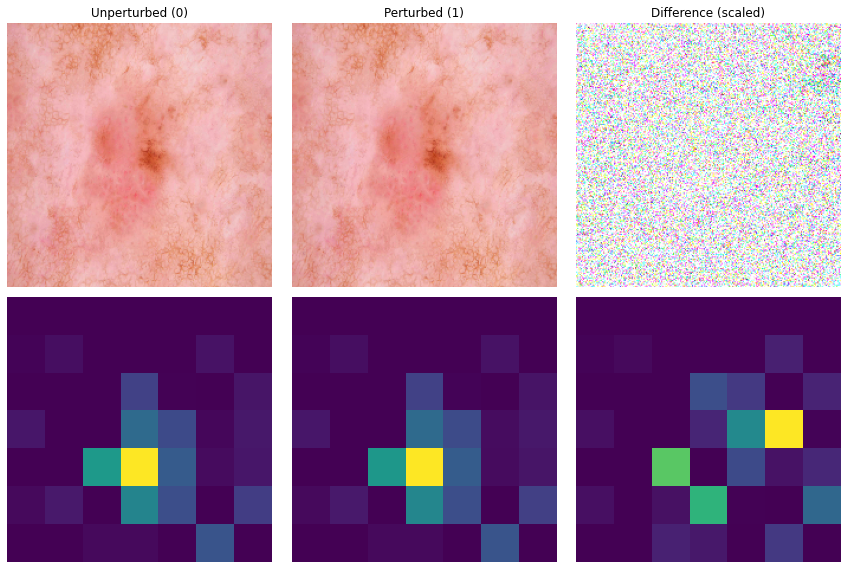

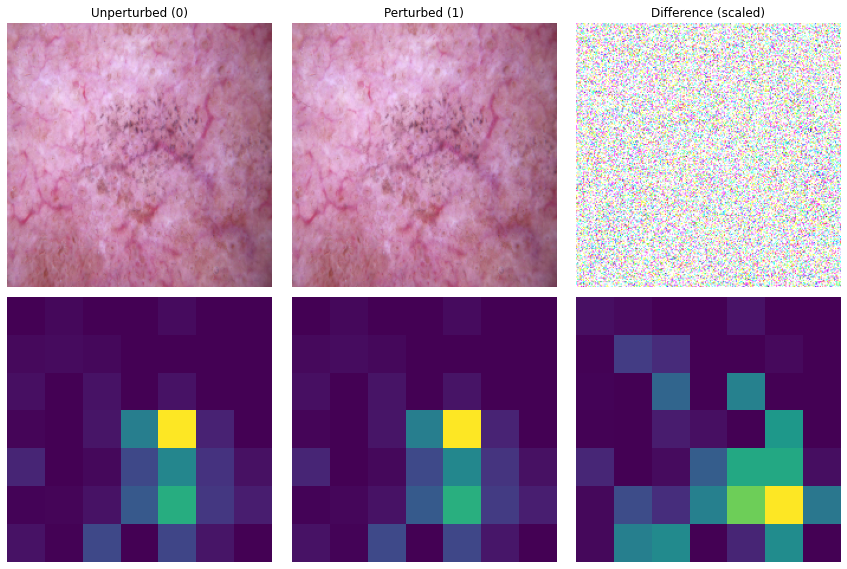

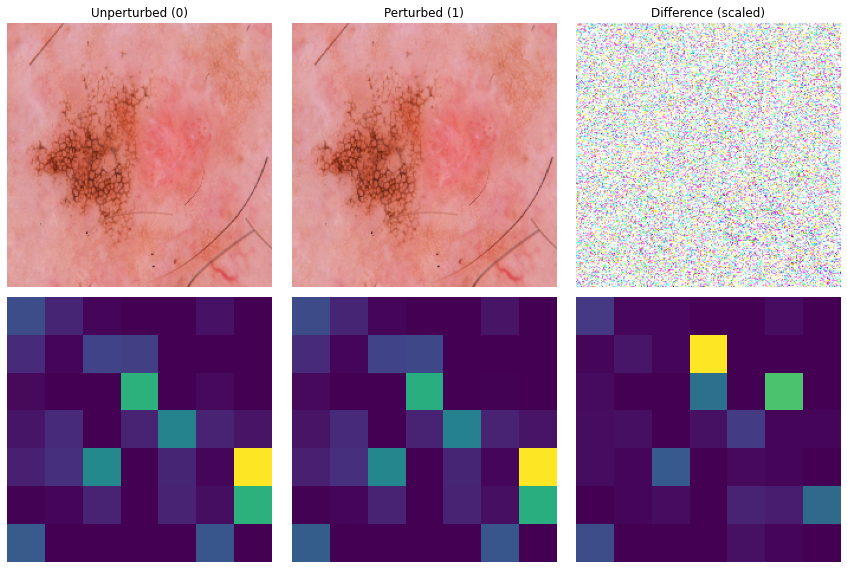

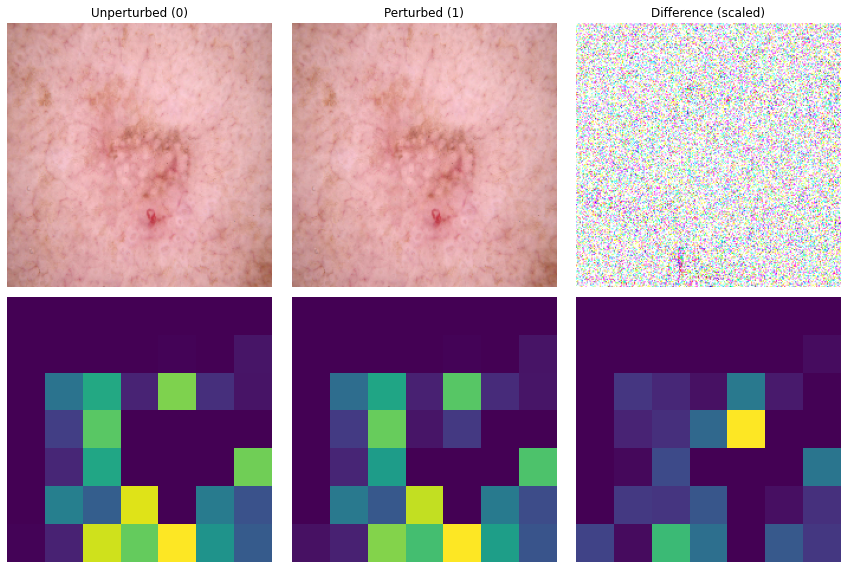

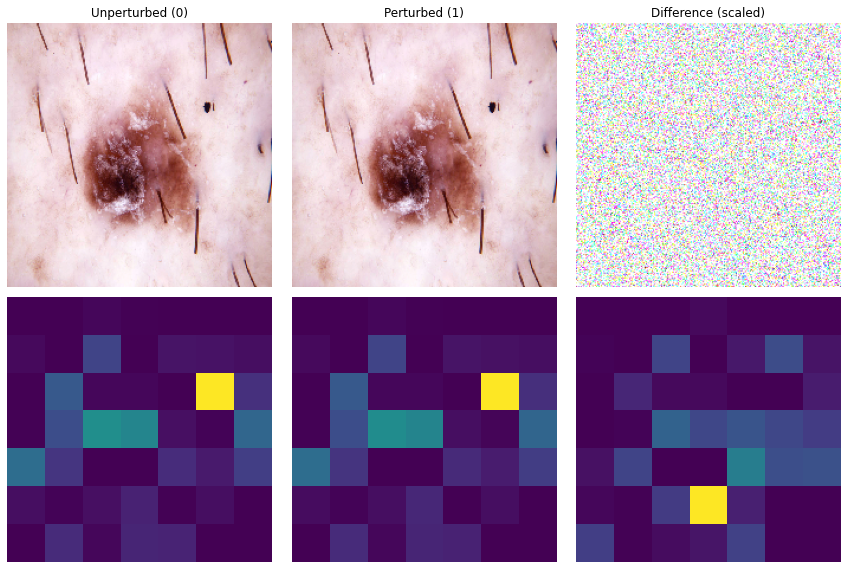

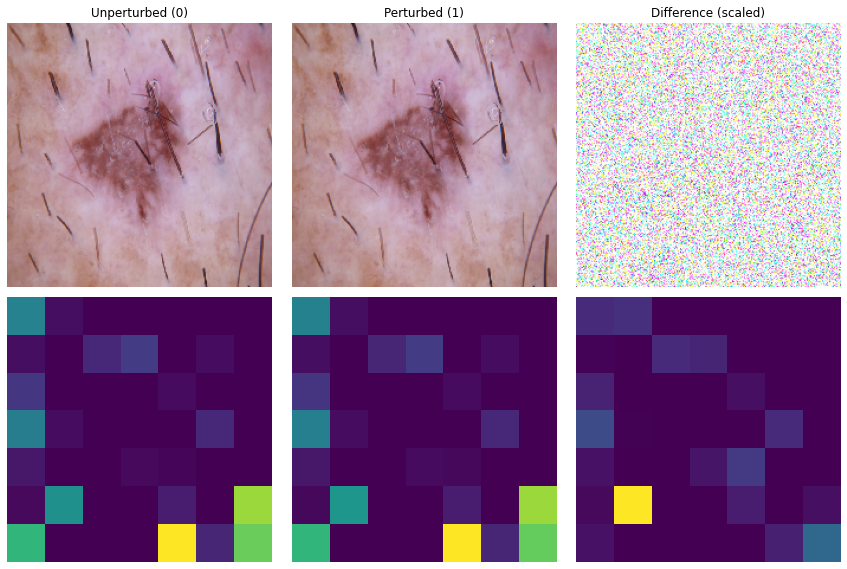

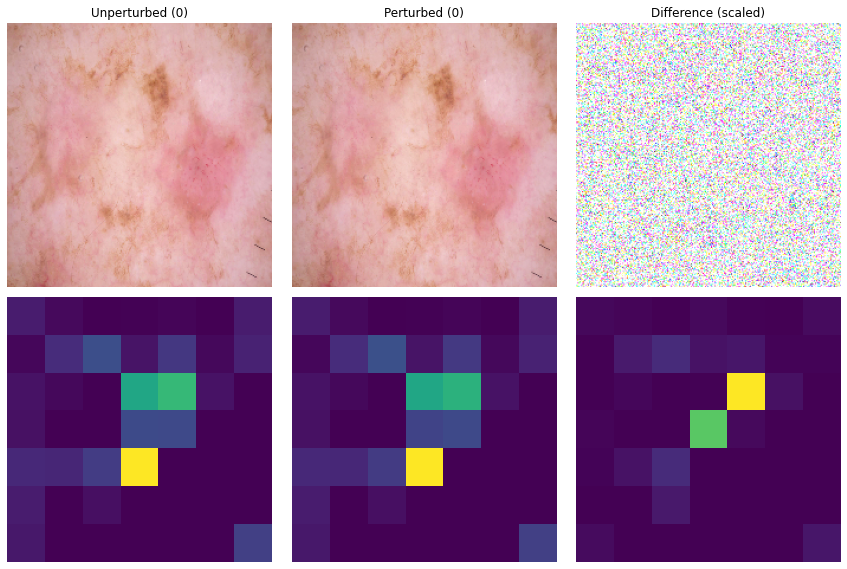

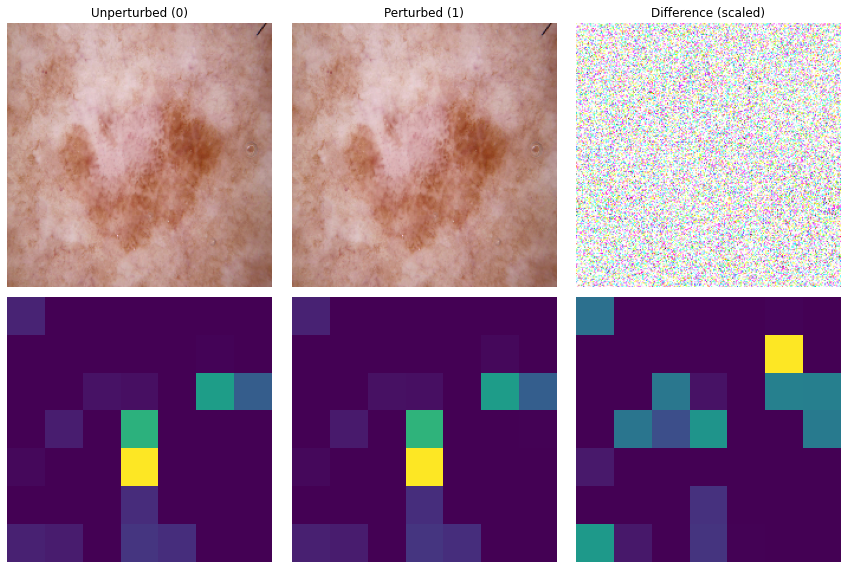

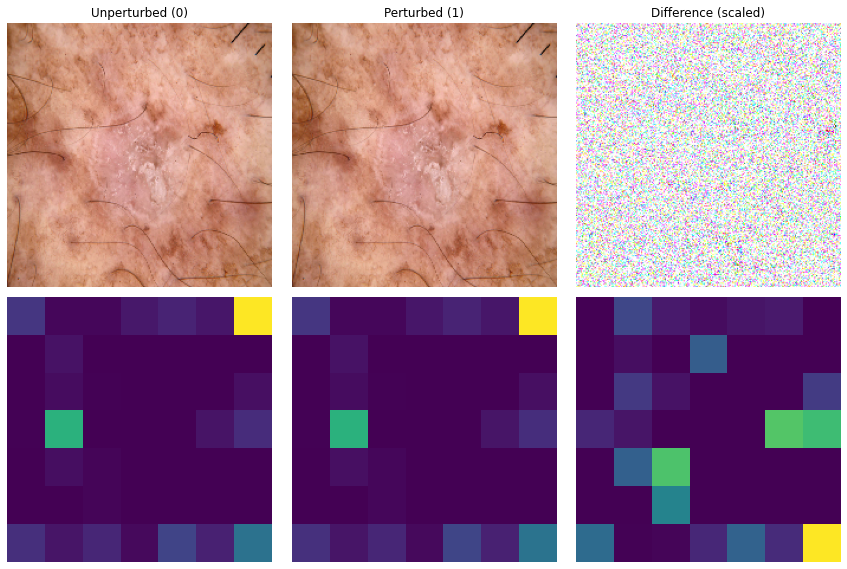

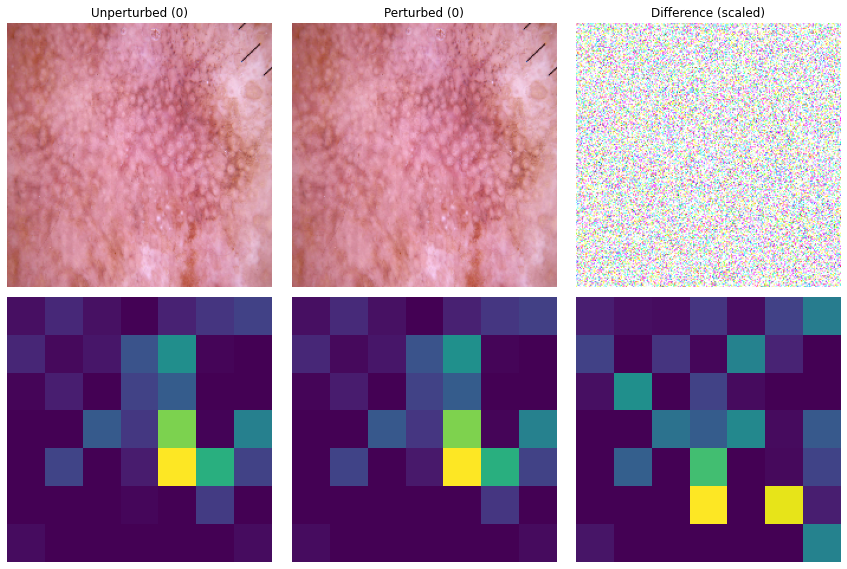

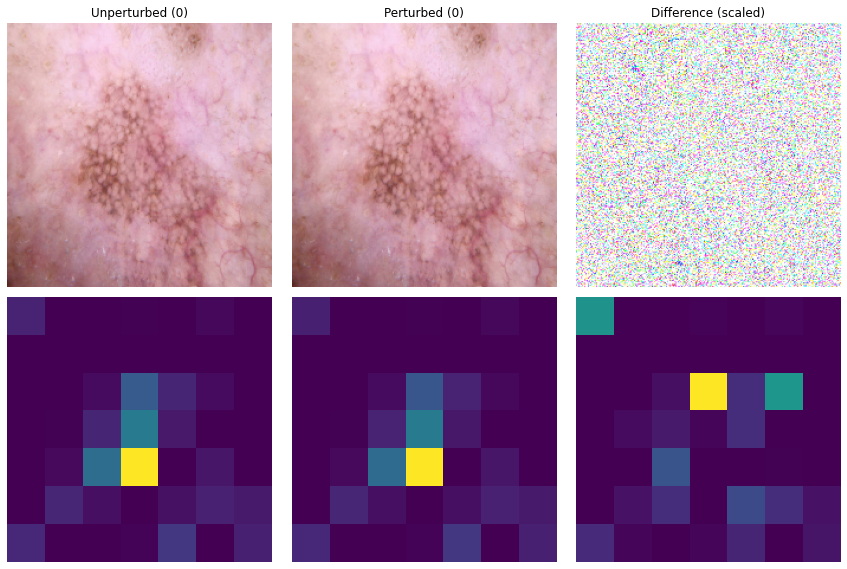

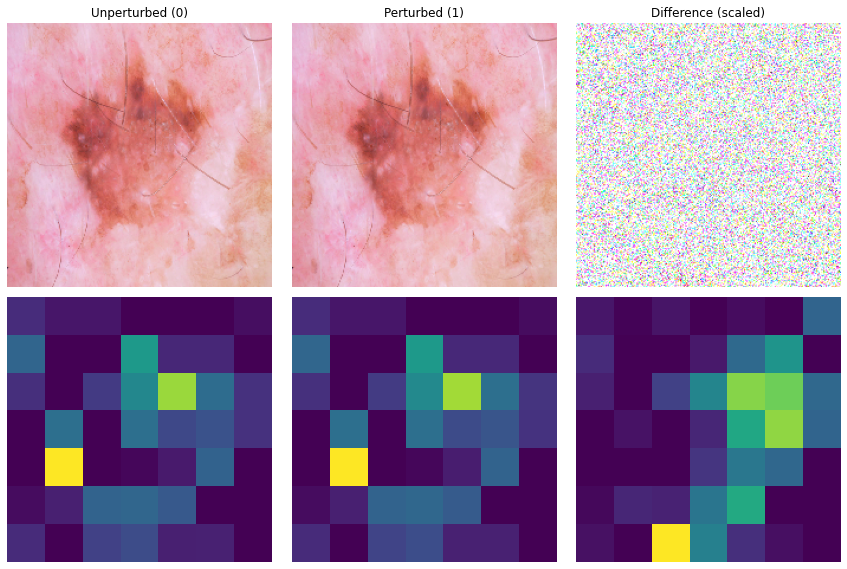

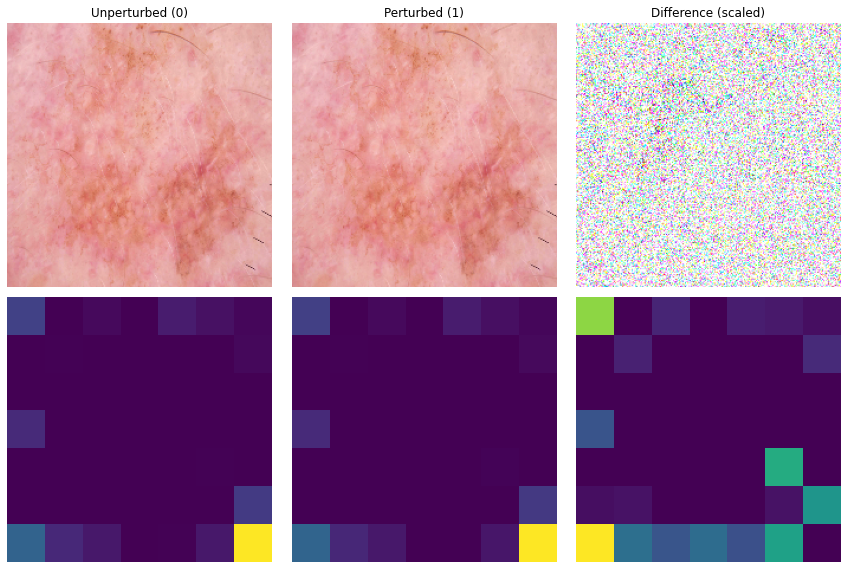

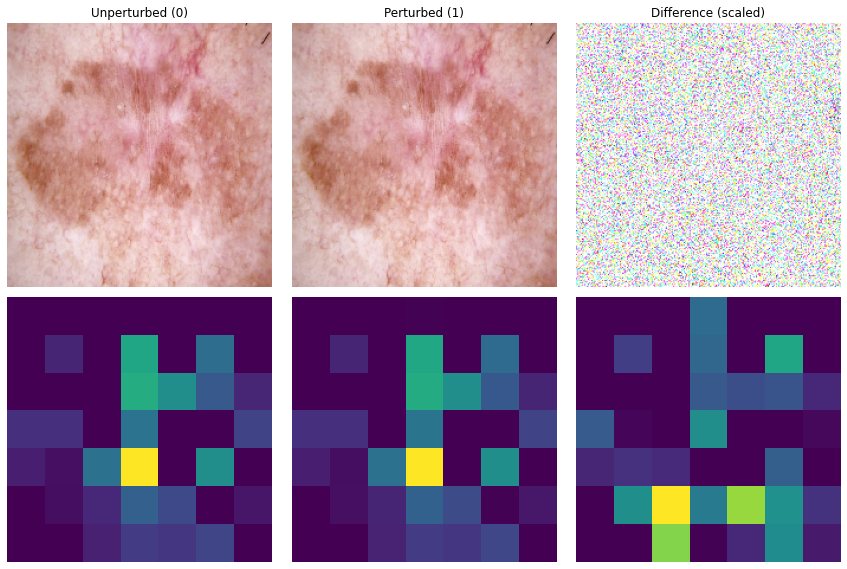

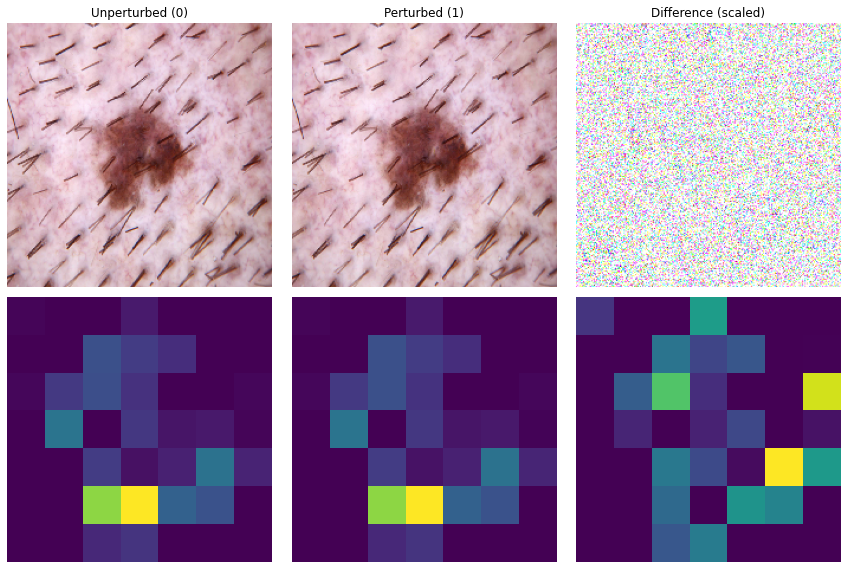

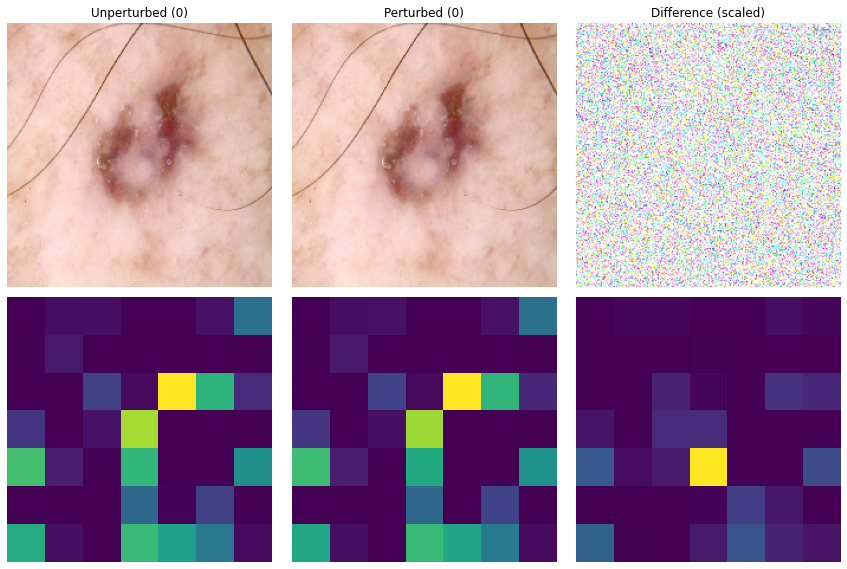

In [23]:
for image_i in range(len(unpert_pert_label_trios)):
    fig, axs = plt.subplots(2,3)
    fig.set_figwidth(12)
    fig.set_figheight(8)

    unperturbed_image = unpert_pert_label_trios[image_i][0]
    unperturbed_image_for_display = invert_preprocess(unperturbed_image)
    unperturbed_image_for_display *= 255 / (np.max(invert_preprocess(unperturbed_image).astype(int)))
    unperturbed_image_for_display = unperturbed_image_for_display.astype(int)
    axs[0,0].imshow(unperturbed_image_for_display)
    axs[0,0].title.set_text(f'Unperturbed ({unpert_pert_label_trios[image_i][2]})')

    perturbed_image = unpert_pert_label_trios[image_i][1]
    perturbed_image_for_display = invert_preprocess(perturbed_image.numpy())
    perturbed_image_for_display *= 255 / (np.max(invert_preprocess(perturbed_image.numpy()).astype(int)))
    perturbed_image_for_display = perturbed_image_for_display.astype(int)
    axs[0,1].imshow(perturbed_image_for_display)
    axs[0,1].title.set_text(f'Perturbed ({int(unpert_pert_label_trios[image_i][3])})')

    diff = cv2.absdiff(unperturbed_image, perturbed_image.numpy())
    diff *= 255 / np.max(diff)
    axs[0,2].imshow(diff.astype(int))
    axs[0,2].title.set_text("Difference (scaled)")

    unperturbed_gradcam = make_gradcam_heatmap(unperturbed_image.reshape((1,224,224,3)), model)
    axs[1,0].imshow(unperturbed_gradcam)
    perturbed_gradcam = make_gradcam_heatmap(perturbed_image.numpy().reshape((1,224,224,3)), model)
    axs[1,1].imshow(perturbed_gradcam)

    diff = cv2.absdiff(unperturbed_gradcam, perturbed_gradcam)
    diff *= 255 / np.max(diff)
    axs[1,2].imshow(diff.astype(int))

    for ax in axs.reshape((6)):
        ax.axis("off")

    plt.tight_layout()
    plt.savefig(f'visualizations/derm/eps_{epsilon}/{model_name}_from_conv/{image_i:02}.pdf')

In [15]:
print(model_name)
model.summary()

without_attention
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                            